In [33]:
import requests
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [34]:
import plotly
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot
from plotly import tools
from warnings import filterwarnings
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

In [35]:
#df_complete = pd.read_csv('C:/Users/tally/Desktop/Sports Analytics/IPL.csv')

# 1. Data Ingestion and Preparation

In [36]:
df2022 = pd.read_csv('C:/Users/tally/Desktop/Sports Analytics/IPL_Ball_by_Ball_2008_2022.csv')
# Create a dictionary to map the column names from df2 to df1
column_mapping = {
    'ID': 'id',
    'innings': 'inning',
    'overs': 'over',
    'ballnumber': 'ball',
    'batter': 'batsman',
    'bowler': 'bowler',
    'non-striker': 'non_striker',
    'extra_type': 'extras_type',
    'batsman_run': 'batsman_runs',
    'extras_run': 'extra_runs',
    'total_run': 'total_runs',
    'non_boundary': 'non_boundary',
    'isWicketDelivery': 'is_wicket',
    'player_out': 'player_dismissed',
    'kind': 'dismissal_kind',
    'fielders_involved': 'fielder',
    'BattingTeam': 'batting_team',
    'bowling_team': 'bowling_team'
}

# Use the rename method to rename the columns in df2 based on the mapping dictionary
df2022 = df2022.rename(columns=column_mapping)


In [37]:
df2022.head()

,id,inning,over,ball,batsman,bowler,non_striker,extras_type,batsman_runs,extra_runs,total_runs,non_boundary,is_wicket,player_dismissed,dismissal_kind,fielder,batting_team
0,1312200,1,0,1,YBK Jaiswal,Mohammed Shami,JC Buttler,NaN,0,0,0,0,0,NaN,NaN,NaN,Rajasthan Royals
1,1312200,1,0,2,YBK Jaiswal,Mohammed Shami,JC Buttler,legbyes,0,1,1,0,0,NaN,NaN,NaN,Rajasthan Royals
2,1312200,1,0,3,JC Buttler,Mohammed Shami,YBK Jaiswal,NaN,1,0,1,0,0,NaN,NaN,NaN,Rajasthan Royals
3,1312200,1,0,4,YBK Jaiswal,Mohammed Shami,JC Buttler,NaN,0,0,0,0,0,NaN,NaN,NaN,Rajasthan Royals
4,1312200,1,0,5,YBK Jaiswal,Mohammed Shami,JC Buttler,NaN,0,0,0,0,0,NaN,NaN,NaN,Rajasthan Royals


## 1.1 Extract df18 from whole dataset - df18 is match data after 2018 IPL Big Auction.

In [38]:
df_18 = df2022[df2022['id'] >981019]
df_18.head()

,id,inning,over,ball,batsman,bowler,non_striker,extras_type,batsman_runs,extra_runs,total_runs,non_boundary,is_wicket,player_dismissed,dismissal_kind,fielder,batting_team
0,1312200,1,0,1,YBK Jaiswal,Mohammed Shami,JC Buttler,NaN,0,0,0,0,0,NaN,NaN,NaN,Rajasthan Royals
1,1312200,1,0,2,YBK Jaiswal,Mohammed Shami,JC Buttler,legbyes,0,1,1,0,0,NaN,NaN,NaN,Rajasthan Royals
2,1312200,1,0,3,JC Buttler,Mohammed Shami,YBK Jaiswal,NaN,1,0,1,0,0,NaN,NaN,NaN,Rajasthan Royals
3,1312200,1,0,4,YBK Jaiswal,Mohammed Shami,JC Buttler,NaN,0,0,0,0,0,NaN,NaN,NaN,Rajasthan Royals
4,1312200,1,0,5,YBK Jaiswal,Mohammed Shami,JC Buttler,NaN,0,0,0,0,0,NaN,NaN,NaN,Rajasthan Royals


In [39]:
# creata a dictionary whose key is the year and value is the id of the first match of that year and the last match of that year start with the whole df 2008

year_dict = {2008: [335982, 336041], 2009: [392181, 392240], 2010: [419106, 419165], 2011: [501198, 501257],
                2012: [548306, 548364], 2013: [598000, 598058], 2014: [729279, 734049], 2015: [829705, 829823],
                2016: [980901, 981019], 2017: [1082591, 1082650], 2018: [1136561, 1136620], 2019: [1175356, 1181768],
                2020: [1216492, 1237181], 2021: [1254058, 1254117], 2022: [1304047, 1312200]}

In [40]:
def add_current_wickets_column(df):
    """
    Adds a new column 'current_wickets' to the input DataFrame,
    which represents the current number of wickets lost for each
    innings (grouped by the 'id' column).
    """
    # Initialize the current wickets to 0 for the first row of each innings
    df['current_wickets'] = 0
    
    # Group the DataFrame by the 'id' column and iterate over each group
    for _, group_df in df.groupby('id'):
        # Get the index of the first row for this group
        first_row_index = group_df.index[0]
        
        # Set the current wickets to 0 for the first row of each innings
        df.at[first_row_index, 'current_wickets'] = 0
        
        # Iterate over the rows for this group, starting from the second row
        for i in range(first_row_index+1, first_row_index+len(group_df)):
            # If the current row has a wicket, increment the current wickets
            if group_df.at[i, 'is_wicket'] == 1:
                df.at[i, 'current_wickets'] = df.at[i-1, 'current_wickets'] + 1
            # Otherwise, copy the current wickets from the previous row
            else:
                df.at[i, 'current_wickets'] = df.at[i-1, 'current_wickets']
    
    return df

In [41]:
def get_weighted_bowlers(df):
    # Create a dictionary to store the weighted values for each bowler
    bowlers = {}

    # Iterate over each row in the dataframe
    for index, row in df.iterrows():
        # Get the current wicket count for this match
        current_wickets = row['current_wickets']

        # Get the bowler name
        bowler = row['bowler']

        # If the bowler is not already in the dictionary, add them with initial values of 0
        if bowler not in bowlers:
            bowlers[bowler] = {'0-2': 0, '2-5': 0, '5-8': 0, '8-10': 0}

        # Increment the appropriate column based on the current wicket count
        if current_wickets <= 2:
            bowlers[bowler]['0-2'] += row['is_wicket']
        elif current_wickets <= 5:
            bowlers[bowler]['2-5'] += row['is_wicket']
        elif current_wickets <= 8:
            bowlers[bowler]['5-8'] += row['is_wicket']
        else:
            bowlers[bowler]['8-10'] += row['is_wicket']

    # Convert the dictionary to a dataframe and return it
    weighted_bowlers = pd.DataFrame.from_dict(bowlers, orient='index')
    weighted_bowlers.index.name = 'bowler'

    weighted_bowlers['weighted_wickets'] = (weighted_bowlers['0-2']*1 + 
                                             weighted_bowlers['2-5']*0.8 + 
                                             weighted_bowlers['5-8']*0.5 + 
                                             weighted_bowlers['8-10']*0.3)
    
    # add a column for the total number of wickets
    weighted_bowlers['total_wickets'] = (weighted_bowlers['0-2'] + weighted_bowlers['2-5'] + weighted_bowlers['5-8'] + weighted_bowlers['8-10'])


    
    # remove all bowlers who have 0 wickets in all categories
    weighted_bowlers = weighted_bowlers[weighted_bowlers['weighted_wickets'] > 0]

    # add a column of percentage of weighted wickets to total wickets

    weighted_bowlers['weighted_wickets_pct'] = (weighted_bowlers['weighted_wickets'] / weighted_bowlers['total_wickets'])*100


    # order the dataframe by the weighted wickets column
    weighted_bowlers = weighted_bowlers.sort_values('weighted_wickets', ascending=False)


    


    return weighted_bowlers

### 2.1 Weighted Wickets Calculation

    Assigning weights to wickets based on the batting position. The higher the batting position, the higher the weight.

In [42]:



df_wick = add_current_wickets_column(df_18)

df_18 = df_wick.copy()
df_wick = get_weighted_bowlers(df_wick)


C:\Users\tally\AppData\Local\Temp\ipykernel_19172\2318255558.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [43]:
# order the dataframe by the total wickets column
weighted_bowler_extra = df_wick.sort_values('total_wickets', ascending=False)

weighted_bowler_extra.head(30)

,0-2,2-5,5-8,8-10,weighted_wickets,total_wickets,weighted_wickets_pct
bowler,,,,,,,
JJ Bumrah,12,28,30,61,67.7,131,51.679389
Rashid Khan,15,39,27,38,71.1,119,59.747899
YS Chahal,15,30,28,41,65.3,114,57.280702
K Rabada,15,20,24,49,57.7,108,53.425926
Mohammed Shami,15,33,19,30,59.9,97,61.752577
TA Boult,14,15,29,30,49.5,88,56.250000
SN Thakur,13,24,21,29,51.4,87,59.080460
B Kumar,12,15,29,20,44.5,76,58.552632
SP Narine,18,26,4,26,48.6,74,65.675676


### 2.2 Selecting targets

    Segmenting Batting and Bowling Targets based on total balls bowled/faced.

In [44]:
BallBowled_counts = df_18['bowler'].value_counts()
BallFaced_counts = df_18['batsman'].value_counts()

BallBowled_counts = pd.DataFrame(BallBowled_counts)

BallBowled_counts.reset_index( inplace=True)


BallFaced_counts = pd.DataFrame(BallFaced_counts)

BallFaced_counts.reset_index( inplace=True)

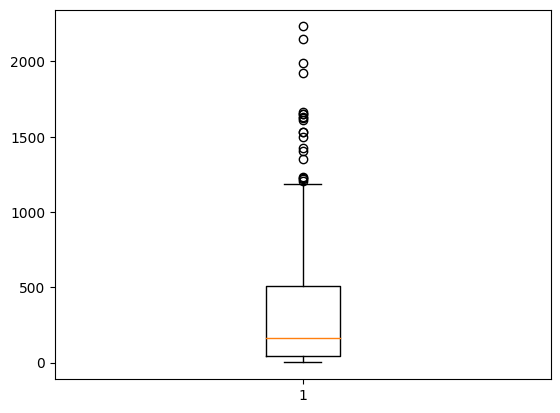

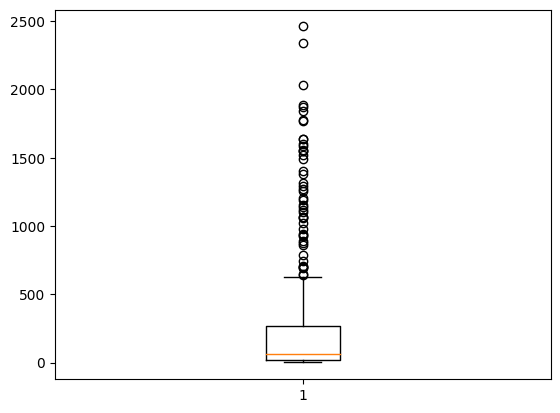

In [45]:
fig,ax =plt.subplots()

ax.boxplot(BallBowled_counts['bowler'])

plt.show()

fig,ax =plt.subplots()

ax.boxplot(BallFaced_counts['batsman'])

plt.show()

In [46]:
MedianBowl = BallBowled_counts['bowler'].median()

MedianBats = BallFaced_counts['batsman'].median()

# Only select the bowlers and batsmen who have bowled and faced more than the median number of balls
# All rounders are players in both categories


Bowling_Targets = BallBowled_counts[BallBowled_counts['bowler']>MedianBowl]

Batting_Targets = BallFaced_counts[BallFaced_counts['batsman']>MedianBats]

# make the column name index in Bowling_Targets as the index 

Bowling_Targets.set_index('index', inplace=True)

# make the column name index in Batting_Targets as the index

Batting_Targets.set_index('index', inplace=True)



In [47]:
# for all unique bowlers in df_18 count the instances where total runs is 0
# add column names dot_count to the Bowling_Targets dataframe

DotRatio = df_18[df_18['total_runs']==0]['bowler'].value_counts()

# convert DotRatio to dataframe
DotRatio = pd.DataFrame(DotRatio)

# rename the column name bowler to dot_count
DotRatio.rename(columns={'bowler':'dot_count'}, inplace=True)

# repeat the process for 1s, 2s, 3s, 4s, 6s
# rename the column name bowler to 1_count, 2_count, 3_count, 4_count, 6_count



DotRatio1 = df_18[df_18['total_runs']==1]['bowler'].value_counts()
DotRatio1 = pd.DataFrame(DotRatio1)
DotRatio1.rename(columns={'bowler':'1_count'}, inplace=True)

DotRatio2 = df_18[df_18['total_runs']==2]['bowler'].value_counts()
DotRatio2 = pd.DataFrame(DotRatio2)
DotRatio2.rename(columns={'bowler':'2_count'}, inplace=True)

DotRatio3 = df_18[df_18['total_runs']==3]['bowler'].value_counts()
DotRatio3 = pd.DataFrame(DotRatio3)
DotRatio3.rename(columns={'bowler':'3_count'}, inplace=True)

DotRatio4 = df_18[df_18['total_runs']==4]['bowler'].value_counts()
DotRatio4 = pd.DataFrame(DotRatio4)
DotRatio4.rename(columns={'bowler':'4_count'}, inplace=True)

DotRatio5 = df_18[df_18['total_runs']==5]['bowler'].value_counts()
DotRatio5 = pd.DataFrame(DotRatio5)
DotRatio5.rename(columns={'bowler':'5_count'}, inplace=True)

DotRatio6 = df_18[df_18['total_runs']==6]['bowler'].value_counts()
DotRatio6 = pd.DataFrame(DotRatio6)
DotRatio6.rename(columns={'bowler':'6_count'}, inplace=True)
# make another dataframe for wickets using is wicket column

DotRatioWicket = df_18[df_18['is_wicket']==1]['bowler'].value_counts()
DotRatioWicket = pd.DataFrame(DotRatioWicket)
DotRatioWicket.rename(columns={'bowler':'wicket_count'}, inplace=True)



In [48]:
# rename bowler column in Bowling_Targets to total balls bowled
Bowling_Targets.rename(columns={'bowler':'total_balls_bowled'}, inplace=True)

# rename bowler column in DotRatio to dot_count
DotRatio.rename(columns={'bowler':'dot_count'}, inplace=True)

# merge Bowling_Targets and DotRatio,DotRatio1, DotRatio2, DotRatio3, DotRatio4, DotRatio5, DotRatio6, DotRatioWicket on index

Bowling_Targets = pd.merge(Bowling_Targets, DotRatio, left_index=True, right_index=True, how='inner')
Bowling_Targets = pd.merge(Bowling_Targets, DotRatio1, left_index=True, right_index=True, how='inner')
Bowling_Targets = pd.merge(Bowling_Targets, DotRatio2, left_index=True, right_index=True, how='inner')
Bowling_Targets = pd.merge(Bowling_Targets, DotRatio3, left_index=True, right_index=True, how='inner')
Bowling_Targets = pd.merge(Bowling_Targets, DotRatio4, left_index=True, right_index=True, how='inner')
Bowling_Targets = pd.merge(Bowling_Targets, DotRatio5, left_index=True, right_index=True, how='inner')
Bowling_Targets = pd.merge(Bowling_Targets, DotRatio6, left_index=True, right_index=True, how='inner')
Bowling_Targets = pd.merge(Bowling_Targets, DotRatioWicket, left_index=True, right_index=True, how='inner')

# add column to both batting and bowling targets called boundary_count which is the sum of 4s and 6s

Bowling_Targets['boundary_count'] = Bowling_Targets['4_count'] + Bowling_Targets['6_count']



C:\Users\tally\AppData\Local\Temp\ipykernel_19172\3241481779.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [49]:
# repeat the process for batting targets

Batting_Targets.rename(columns={'batsman':'total_balls_faced'}, inplace=True)

DotRatioBats = df_18[df_18['total_runs']==0]['batsman'].value_counts()
DotRatioBats = pd.DataFrame(DotRatioBats)
DotRatioBats.rename(columns={'batsman':'dot_count'}, inplace=True)

DotRatioBats1 = df_18[df_18['total_runs']==1]['batsman'].value_counts()
DotRatioBats1 = pd.DataFrame(DotRatioBats1)
DotRatioBats1.rename(columns={'batsman':'1_count'}, inplace=True)

DotRatioBats2 = df_18[df_18['total_runs']==2]['batsman'].value_counts()
DotRatioBats2 = pd.DataFrame(DotRatioBats2)
DotRatioBats2.rename(columns={'batsman':'2_count'}, inplace=True)

DotRatioBats3 = df_18[df_18['total_runs']==3]['batsman'].value_counts()
DotRatioBats3 = pd.DataFrame(DotRatioBats3)
DotRatioBats3.rename(columns={'batsman':'3_count'}, inplace=True)

DotRatioBats4 = df_18[df_18['total_runs']==4]['batsman'].value_counts()
DotRatioBats4 = pd.DataFrame(DotRatioBats4)
DotRatioBats4.rename(columns={'batsman':'4_count'}, inplace=True)

DotRatioBats5 = df_18[df_18['total_runs']==5]['batsman'].value_counts()
DotRatioBats5 = pd.DataFrame(DotRatioBats5)
DotRatioBats5.rename(columns={'batsman':'5_count'}, inplace=True)

DotRatioBats6 = df_18[df_18['total_runs']==6]['batsman'].value_counts()
DotRatioBats6 = pd.DataFrame(DotRatioBats6)
DotRatioBats6.rename(columns={'batsman':'6_count'}, inplace=True)

DotRatioBatsWicket = df_18[df_18['is_wicket']==1]['batsman'].value_counts()
DotRatioBatsWicket = pd.DataFrame(DotRatioBatsWicket)
DotRatioBatsWicket.rename(columns={'batsman':'wicket_count'}, inplace=True)

Batting_Targets = pd.merge(Batting_Targets, DotRatioBats, left_index=True, right_index=True, how='inner')
Batting_Targets = pd.merge(Batting_Targets, DotRatioBats1, left_index=True, right_index=True, how='inner')
Batting_Targets = pd.merge(Batting_Targets, DotRatioBats2, left_index=True, right_index=True, how='inner')
Batting_Targets = pd.merge(Batting_Targets, DotRatioBats3, left_index=True, right_index=True, how='inner')
Batting_Targets = pd.merge(Batting_Targets, DotRatioBats4, left_index=True, right_index=True, how='inner')
Batting_Targets = pd.merge(Batting_Targets, DotRatioBats5, left_index=True, right_index=True, how='inner')
Batting_Targets = pd.merge(Batting_Targets, DotRatioBats6, left_index=True, right_index=True, how='inner')
Batting_Targets = pd.merge(Batting_Targets, DotRatioBatsWicket, left_index=True, right_index=True, how='inner')

# add column to both batting and bowling targets called boundary_count which is the sum of 4s and 6s

Batting_Targets['boundary_count'] = Batting_Targets['4_count'] + Batting_Targets['6_count']




C:\Users\tally\AppData\Local\Temp\ipykernel_19172\3271105977.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [50]:
Bowling_Targets

,total_balls_bowled,dot_count,1_count,2_count,3_count,4_count,5_count,6_count,wicket_count,boundary_count
Rashid Khan,2232,852,1014,114,6,161,3,82,119,243
JJ Bumrah,2146,844,827,165,15,223,6,65,131,288
YS Chahal,1992,688,922,114,7,142,3,116,114,258
SP Narine,1922,679,887,118,6,148,3,81,74,229
R Ashwin,1665,486,875,102,4,117,1,80,64,197
B Kumar,1654,670,592,125,7,191,3,66,76,257
TA Boult,1653,669,554,91,4,255,4,76,88,331
SN Thakur,1630,557,624,130,8,219,4,88,87,307
Mohammed Shami,1624,638,559,96,6,234,9,82,97,316
KH Pandya,1531,476,769,101,1,125,1,57,58,182


In [51]:
Batting_Targets

,total_balls_faced,dot_count,1_count,2_count,3_count,4_count,5_count,6_count,wicket_count,boundary_count
S Dhawan,2461,774,1103,141,9,355,4,75,84,430
KL Rahul,2341,741,1026,158,3,272,1,140,58,412
V Kohli,2029,625,942,160,10,220,2,70,78,290
SS Iyer,1889,598,888,123,7,194,2,77,74,271
DA Warner,1873,584,772,175,13,241,6,81,52,322
RR Pant,1845,555,799,119,1,246,2,122,78,368
JC Buttler,1766,614,637,125,5,257,4,122,60,379
F du Plessis,1640,558,685,104,9,209,4,71,59,280
RG Sharma,1636,632,631,88,6,200,2,76,82,276
N Rana,1599,588,648,67,6,186,1,102,76,288


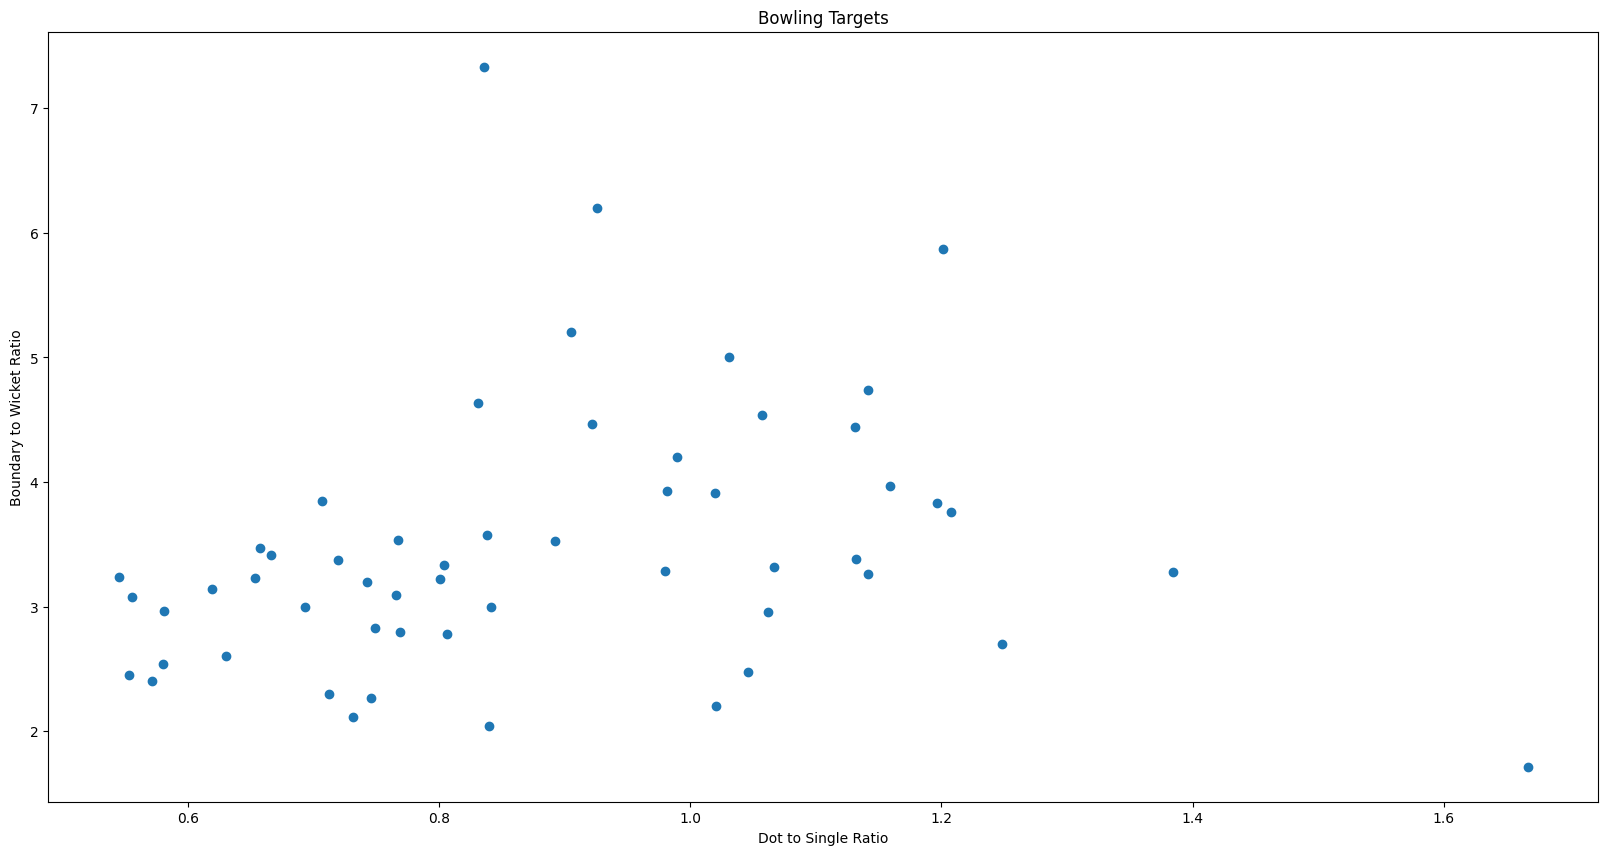

In [52]:
# build a plot which plots the ratio of dot_count to 1_count on the x axis and the ratio of boundary_count to wicket_count on the y axis
# add the name of the bowler as the label for each point

plt.figure(figsize=(20,10))
plt.scatter(Bowling_Targets['dot_count']/Bowling_Targets['1_count'], Bowling_Targets['boundary_count']/Bowling_Targets['wicket_count'])
plt.xlabel('Dot to Single Ratio')
plt.ylabel('Boundary to Wicket Ratio')
plt.title('Bowling Targets')
plt.show()




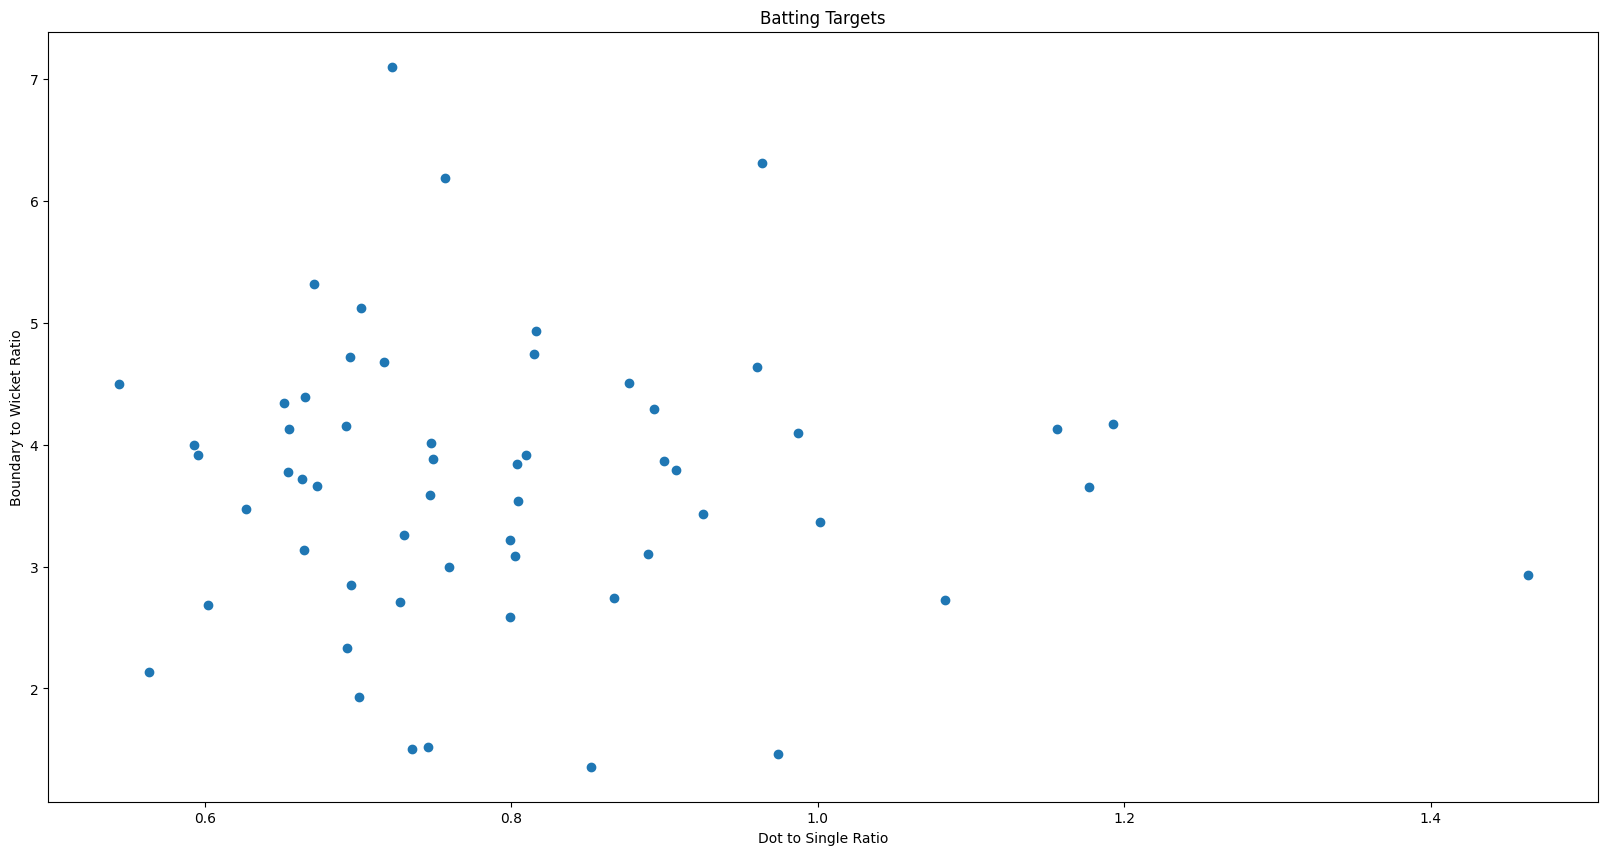

In [53]:
# build a plot which plots the ratio of dot_count to 1_count on the x axis and the ratio of boundary_count to wicket_count on the y axis for the Batting_Targets

plt.figure(figsize=(20,10))
plt.scatter(Batting_Targets['dot_count']/Batting_Targets['1_count'], Batting_Targets['boundary_count']/Batting_Targets['wicket_count'])
plt.xlabel('Dot to Single Ratio')
plt.ylabel('Boundary to Wicket Ratio')
plt.title('Batting Targets')
plt.show()


In [54]:
def run_by_overs(df):
  
  df1 = df[df['batsman_runs']==1]
  df2 = df[df['batsman_runs']==2]
  df3 = df[df['batsman_runs']==3]
  df4 = df[df['batsman_runs']==4]
  df5 = df[df['batsman_runs']==5]
  df6 = df[df['batsman_runs']==6]

  answer = []

  r1 = over_count(df1,1)
  answer.append([1,r1])
  r2 = over_count(df2,2)
  answer.append([2,r2])
  r3 = over_count(df3,3)
  answer.append([3,r3])
  r4 = over_count(df4,4)
  answer.append([4,r4])
  r5 = over_count(df5,5)
  answer.append([5,r5])
  r6 = over_count(df6,6)
  answer.append([6,r6])

  return answer

def over_count(df,run):

  counters = []
  pp    = len(df[df['over']<=6])*run
  mid = len(df[(df['over']>6) & (df['over']<=11)])*run
  drink = len(df[(df['over']>11) & (df['over']<=16)])*run
  end   = len(df[df['over']>=16])*run

  counters.append(pp)
  counters.append(mid)
  counters.append(drink)
  counters.append(end)

  return counters


def runs_by_segment(df):
    # initialize a dictionary to store the counts
    counts = {1: [0, 0, 0, 0], 2: [0, 0, 0, 0], 3: [0, 0, 0, 0], 4: [0, 0, 0, 0], 5: [0, 0, 0, 0], 6: [0, 0, 0, 0]}

    # loop through all the runs from 1 to 6
    for run in range(1, 7):
        # filter the DataFrame for the current run
        df_run = df[df['batsman_runs'] == run]
        
        # count the instances of the current run in the pp segment
        counts[run][0] = len(df_run[df_run['over'] <= 6])
        
        # count the instances of the current run in the mid segment
        counts[run][1] = len(df_run[(df_run['over'] > 6) & (df_run['over'] <= 11)])
        
        # count the instances of the current run in the drink segment
        counts[run][2] = len(df_run[(df_run['over'] > 11) & (df_run['over'] <= 16)])
        
        # count the instances of the current run in the end segment
        counts[run][3] = len(df_run[df_run['over'] >= 16])
    
    return counts

def runs_by_segment2(df):
    # initialize a dictionary to store the counts
    counts = {'pp': [0, 0, 0, 0, 0, 0], 'mid': [0, 0, 0, 0, 0, 0], 'drink': [0, 0, 0, 0, 0,0], 'end': [0, 0, 0, 0,0,0]}

    # loop through all the runs from 1 to 6
    for run in range(1, 7):
        # filter the DataFrame for the current run
        df_run = df[df['batsman_runs'] == run]
        
        # count the instances of the current run in the pp segment
        counts['pp'][run-1] = len(df_run[df_run['over'] <= 6])
        
        # count the instances of the current run in the mid segment
        counts['mid'][run-1] = len(df_run[(df_run['over'] > 6) & (df_run['over'] <= 11)])
        
        # count the instances of the current run in the drink segment
        counts['drink'][run-1] = len(df_run[(df_run['over'] > 11) & (df_run['over'] <= 16)])
        
        # count the instances of the current run in the end segment
        counts['end'][run-1] = len(df_run[df_run['over'] >= 16])
    
    return counts

def striker_segment_count(df):
    # create an empty dictionary to store the counts
    counts = {}

    # get a list of unique players
    players = df['batsman'].unique()
    
    # loop through the list of players
    for player in players:
        # filter the DataFrame for the current player
        df_player = df[df['batsman'] == player]
        
        # initialize an empty dictionary to store the counts for each segment
        segment_counts = {'pp': 0, 'mid': 0, 'drink': 0, 'end': 0}
        
        # count the instances of the player playing as striker in the Powerplay segment
        segment_counts['pp'] = len(df_player[(df_player['over'] <= 6)])
        
        # count the instances of the player playing as striker in the Mid segment
        segment_counts['mid'] = len(df_player[(df_player['over'] > 6) & (df_player['over'] <= 11)])
        
        # count the instances of the player playing as striker in the Drink segment
        segment_counts['drink'] = len(df_player[(df_player['over'] > 11) & (df_player['over'] <= 16)])
        
        # count the instances of the player playing as striker in the End segment
        segment_counts['end'] = len(df_player[df_player['over'] > 16])
        
        # add the player and their counts to the dictionary
        counts[player] = segment_counts
    
    return counts

def bowler_segment_count(df):
    # create an empty dictionary to store the counts
    counts = {}

    # get a list of unique players
    players = df['bowler'].unique()
    
    # loop through the list of players
    for player in players:
        # filter the DataFrame for the current player
        df_player = df[df['bowler'] == player]
        
        # initialize an empty dictionary to store the counts for each segment
        segment_counts = {'pp': 0, 'mid': 0, 'drink': 0, 'end': 0}
        
        
        # count the instances of the player playing as striker in the Powerplay segment
        segment_counts['pp'] = len(df_player[(df_player['over'] <= 6)])
        
        # count the instances of the player playing as striker in the Mid segment
        segment_counts['mid'] = len(df_player[(df_player['over'] > 6) & (df_player['over'] <= 11)])
        
        # count the instances of the player playing as striker in the Drink segment
        segment_counts['drink'] = len(df_player[(df_player['over'] > 11) & (df_player['over'] <= 16)])
        
        # count the instances of the player playing as striker in the End segment
        segment_counts['end'] = len(df_player[df_player['over'] > 16])
        
        # add the player and their counts to the dictionary
        counts[player] = segment_counts
    
    return counts



def NONstriker_segment_count(df):
    # create an empty dictionary to store the counts
    counts = {}

    # get a list of unique players
    players = df['non_striker'].unique()
    
    # loop through the list of players
    for player in players:
        # filter the DataFrame for the current player
        df_player = df[df['non_striker'] == player]
        
        # initialize an empty dictionary to store the counts for each segment
        segment_counts = {'pp': 0, 'mid': 0, 'drink': 0, 'end': 0}
        
        # count the instances of the player playing as striker in the Powerplay segment
        segment_counts['pp'] = len(df_player[(df_player['over'] <= 6)])
        
        # count the instances of the player playing as striker in the Mid segment
        segment_counts['mid'] = len(df_player[(df_player['over'] > 6) & (df_player['over'] <= 11)])
        
        # count the instances of the player playing as striker in the Drink segment
        segment_counts['drink'] = len(df_player[(df_player['over'] > 11) & (df_player['over'] <= 16)])
        
        # count the instances of the player playing as striker in the End segment
        segment_counts['end'] = len(df_player[df_player['over'] > 16])
        
        # add the player and their counts to the dictionary
        counts[player] = segment_counts
    
    return counts


In [55]:
def plot_runs_by_segment(df):
    counts = runs_by_segment2(df)
    labels = list(counts.keys())
    run1 = []
    run2 = []
    run3 = []
    run4 = []
    run5 = []
    run6 = []

    for segments in counts:
        run1.append(counts[segments][0])
        run2.append(counts[segments][1])
        run3.append(counts[segments][2])
        run4.append(counts[segments][3])
        run5.append(counts[segments][4])
        run6.append(counts[segments][5])
    
    run1Values = []
    run2Values = []
    run3Values = []
    run4Values = []
    run5Values = []
    run6Values = []


    for segments in counts:
        run1Values.append((counts[segments][0])*1)
        run2Values.append((counts[segments][1])*2)
        run3Values.append((counts[segments][2])*3)
        run4Values.append((counts[segments][3])*4)
        run5Values.append((counts[segments][4])*5)
        run6Values.append((counts[segments][5])*6)
  

    width = 0.35
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    ax[0].bar(labels, run1, width,bottom= 1,  label='1')
    ax[0].bar(labels, run2, width,bottom = 2, label='2')
    ax[0].bar(labels, run3, width,bottom = 3,  label='3')
    ax[0].bar(labels, run4, width, bottom = 4,label='4')
    ax[0].bar(labels, run5, width, bottom = 5,label='5')
    ax[0].bar(labels, run6, width, bottom = 6,label='6')



    ax[0].set_ylabel('Runs')
    ax[0].set_xlabel('Runs')
    ax[0].set_title('Runs(Instance/Count) by Over')
    ax[0].legend()

    ax[1].bar(labels, run1Values, width,bottom = run1Values,   label='1')
    ax[1].bar(labels, run2Values, width,bottom = run2Values, label='2')
    ax[1].bar(labels, run3Values, width,bottom = run3Values,  label='3')
    ax[1].bar(labels, run4Values, width, bottom = run4Values,label='4')
    ax[1].bar(labels, run5Values, width, bottom = run5Values,label='5')
    ax[1].bar(labels, run6Values, width, bottom = run6Values,label='6')



    ax[1].set_ylabel('Runs')
    ax[1].set_xlabel('Runs')
    ax[1].set_title('Runs Value by Over')
    ax[1].legend()

    

    plt.show()




In [56]:
colors = ['turquoise', 'crimson']
def count_bowl(df,runs):
    return len(df[df['batsman_runs']==runs])*runs

# make a function which calcultes the runs based on the over number 

def runs_over(over):
    filt=(df_18['over']==over)
    df_over=df_18[filt]
    return df_over['total_runs'].sum()



def Bowler_Analysis(Bowler):
  filt=(df_18['bowler']==Bowler)
  df_bowl=df_18[filt]

  print("Dot Balls :",len(df_bowl[df_bowl['total_runs']==0]))
  print("Runs given from 1's :",count_bowl(df_bowl,1))
  print("Runs given from 2's :",count_bowl(df_bowl,2))
  print("Runs given from 3's :",count_bowl(df_bowl,3))
  print("Runs given from 4's :",count_bowl(df_bowl,4))
  print("Runs given from 6's :",count_bowl(df_bowl,6))
  print("Extras :",len(df_bowl[df_bowl['extra_runs']==1]))
  print("Wickets :",len(df_bowl[df_bowl['is_wicket']==1]))

  runs_total = df_bowl['total_runs'].sum()
  balls_total = len(df_bowl['batsman_runs'])
  
  print(" Runs Given per Ball :", round((runs_total/balls_total),2))

  # make plot neater and beautiful


  values = df_bowl['dismissal_kind'].value_counts()
  labels=df_bowl['dismissal_kind'].value_counts().index
  fig = go.Figure(data=[go.Pie(labels=labels,values=values,hole=.3)])
  fig.update_traces(hoverinfo='label+percent', textinfo='label', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=3)))
  fig.update_layout(title="Wicket Type",
                  titlefont={'size': 30},
                  )
  fig.show()

  plot_runs_by_segment(df_bowl)

  play_count = bowler_segment_count(df_bowl)
  label2 = list(play_count.keys())
  pp = []
  mid = []
  drink = []
  end = []
  for player in play_count:
       pp.append(play_count[player]['pp'])
       mid.append(play_count[player]['mid'])
       drink.append(play_count[player]['drink'])
       end.append(play_count[player]['end'])
  
  width = 0.35
  fig, ax = plt.subplots(figsize=(10,5))
  ax.bar(label2, pp, width, label='Powerplay')
  ax.bar(label2, mid, width, label='Middle')
  ax.bar(label2, drink, width, label='Drinks')
  ax.bar(label2, end, width, label='End')
  
  ax.set_ylabel('Bowling Segment')
  ax.set_xlabel('Bowler')
  ax.set_title('Over Bowled in Segment by Bowler')
  ax.legend()

  #calculate the extra runs given by the bowler in each segment

  
  

# 4.1 Bowler Analysis

In [57]:
# copy index to a new column called name in Bowling_Targets
Bowling_Targets['name'] = Bowling_Targets.index
widgets.interact(Bowler_Analysis, Bowler = Bowling_Targets['name'])



interactive(children=(Dropdown(description='Bowler', options=('Rashid Khan', 'JJ Bumrah', 'YS Chahal', 'SP Nar…

<function __main__.Bowler_Analysis(Bowler)>

In [58]:
def count_run(df,runs):
    return len(df[df['batsman_runs']==runs])*runs

def Batsman_Analysis(Batter):
  filt=(df_18['batsman']==Batter)
  df_bat=df_18[filt]

  print("Dot Ball's :",len(df_bat[df_bat['batsman_runs']==0]))
  print("Runs scored from 1's :",count_run(df_bat,1))
  print("Runs scored from 2's :",count_run(df_bat,2))
  print("Runs scored from 3's :",count_run(df_bat,3))
  print("Runs scored from 4's :",count_run(df_bat,4))
  print("Runs scored from 6's :",count_run(df_bat,6))

  runs_total = df_bat['total_runs'].sum()
  balls_total = len(df_bat['batsman_runs'])
  
  print(" Runs per Ball :", round((runs_total/balls_total),2))



  values = df_bat['dismissal_kind'].value_counts()
  labels=df_bat['dismissal_kind'].value_counts().index
  fig = go.Figure(data=[go.Pie(labels=labels,values=values,hole=.3)])
  fig.update_traces(hoverinfo='label+percent', textinfo='label', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=3)))
  fig.update_layout(title="Dismissal Type",
                  titlefont={'size': 30},
                  )
  fig.show()

  plot_runs_by_segment(df_bat)

  play_count = striker_segment_count(df_bat)
  print("Here-------------")
  print(play_count)
  label2 = list(play_count.keys())
  pp = []
  mid = []
  drink = []
  end = []
  for player in play_count:
       pp.append(play_count[player]['pp'])
       mid.append(play_count[player]['mid'])
       drink.append(play_count[player]['drink'])
       end.append(play_count[player]['end'])
  
  width = 0.35
  fig, ax = plt.subplots(figsize=(10,5))
  ax.bar(label2, pp, width, label='Powerplay')
  ax.bar(label2, mid, width, label='Middle')
  ax.bar(label2, drink, width, label='Drinks')
  ax.bar(label2, end, width, label='End')

  ax.set_ylabel('Batting Segment')
  ax.set_xlabel('Batsman')
  ax.set_title('Batting Segment by Batsman')
  ax.legend()
  

# 4.2 Batsman Analysis

In [59]:
Batting_Targets['name'] = Batting_Targets.index
widgets.interact(Batsman_Analysis, Batter = Batting_Targets['name'])

interactive(children=(Dropdown(description='Batter', options=('S Dhawan', 'KL Rahul', 'V Kohli', 'SS Iyer', 'D…

<function __main__.Batsman_Analysis(Batter)>

In [60]:
def count_run(df,runs):
    return len(df[df['batsman_runs']==runs])*runs

def Non_Striker_Analysis(Batter):
  filt=(df_18['non_striker']==Batter)
  df_bat=df_18[filt]

  print("Dot Ball's :",len(df_bat[df_bat['batsman_runs']==0]))
  print("Runs scored from 1's :",count_run(df_bat,1))
  print("Runs scored from 2's :",count_run(df_bat,2))
  print("Runs scored from 3's :",count_run(df_bat,3))
  print("Runs scored from 4's :",count_run(df_bat,4))
  print("Runs scored from 6's :",count_run(df_bat,6))

  runs_total = df_bat['total_runs'].sum()
  balls_total = len(df_bat['batsman_runs'])
  
  print(" Runs per Ball :", round((runs_total/balls_total),2))


  values = df_bat['dismissal_kind'].value_counts()
  labels=df_bat['dismissal_kind'].value_counts().index
  fig = go.Figure(data=[go.Pie(labels=labels,values=values,hole=.3)])
  fig.update_traces(hoverinfo='label+percent', textinfo='label', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=3)))
  fig.update_layout(title="Dismissal Type",
                  titlefont={'size': 30},
                  )
  fig.show()

  # use the plot_runs_by_segment function to plot the runs scored by the batsman in each over
  plot_runs_by_segment(df_bat)

  # use the striker_segment_count function to plot the runs scored by the batsman in each segment
  play_count = NONstriker_segment_count(df_bat)
  label2 = list(play_count.keys())
  pp = []
  mid = []
  drink = []
  end = []
  for player in play_count:
    pp.append(play_count[player]['pp'])
    mid.append(play_count[player]['mid'])
    drink.append(play_count[player]['drink'])
    end.append(play_count[player]['end'])

  width = 0.35
  fig, ax = plt.subplots(figsize=(10,5))
  ax.bar(label2, pp, width, label='Powerplay')
  ax.bar(label2, mid, width, label='Middle')
  ax.bar(label2, drink, width, label='Drinks')
  ax.bar(label2, end, width, label='End')

  ax.set_ylabel('Batting Segment')
  ax.set_xlabel('Non Striker')
  ax.set_title('Batting Segment by Non Striker')
  ax.legend()



  
  

# 4.3 Non-Striker Analysis

In [61]:
Batting_Targets['name'] = Batting_Targets.index
widgets.interact(Non_Striker_Analysis, Batter = Batting_Targets['name'])

interactive(children=(Dropdown(description='Batter', options=('S Dhawan', 'KL Rahul', 'V Kohli', 'SS Iyer', 'D…

<function __main__.Non_Striker_Analysis(Batter)>

# Value Targets

    80% of the matches when the target is 170+ have been won by the team batting first. 
    Hence the aim is to reach a total of 180 runs. This means that each ball is worth 1.5 runs
    

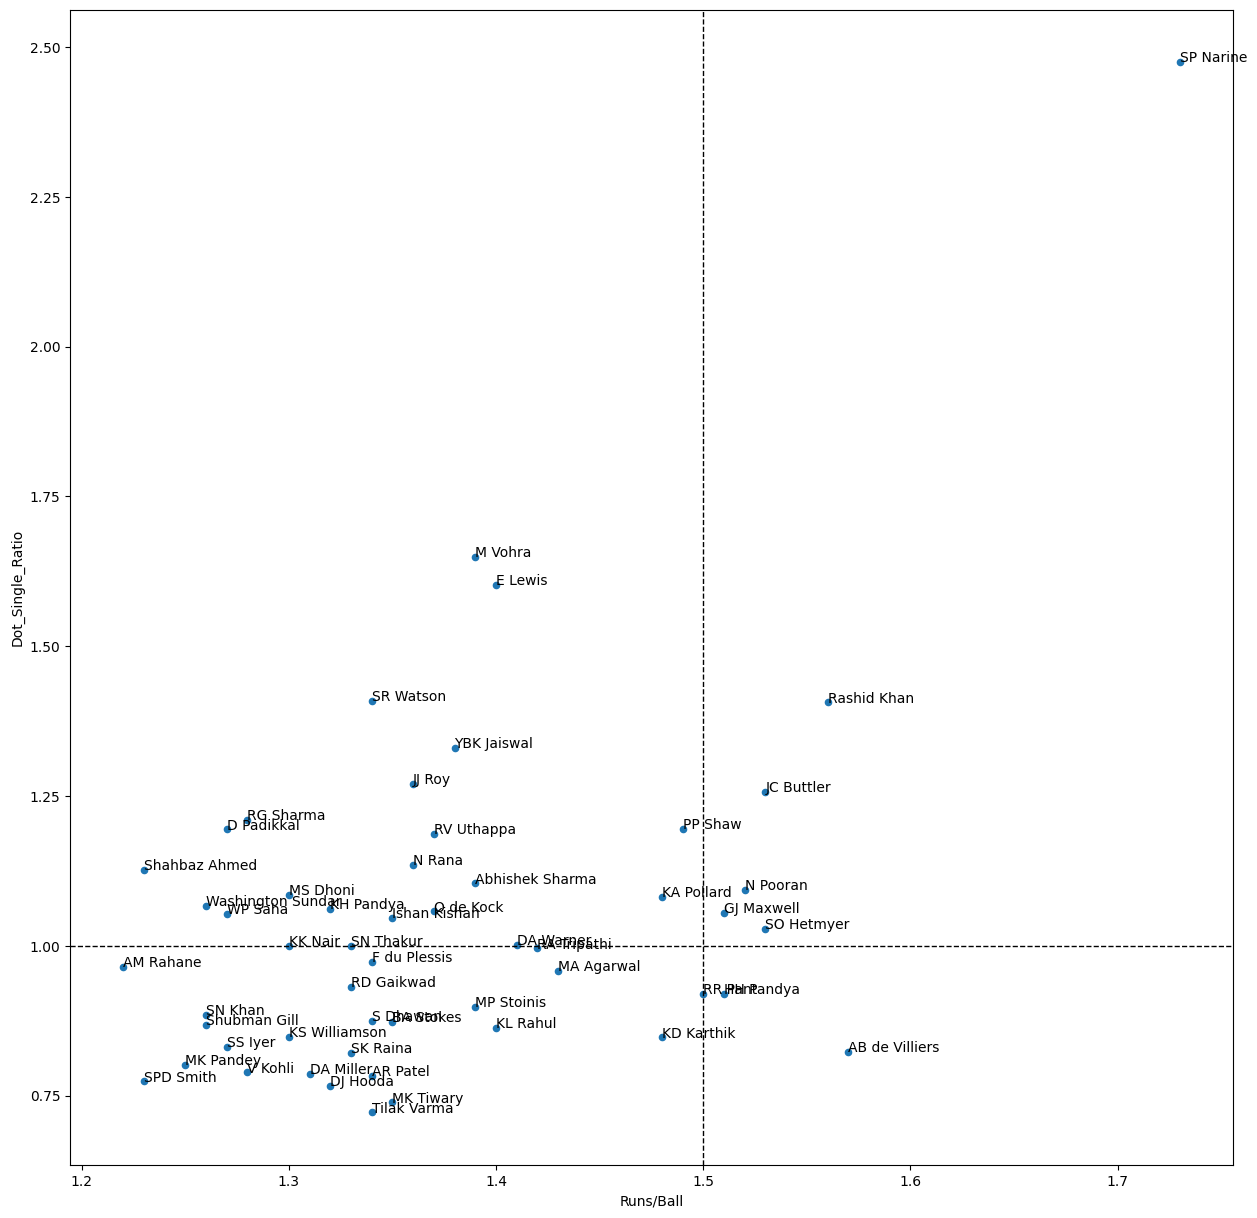

In [62]:
triall3 = []
for name in Batting_Targets['name']:
  x = df_18[df_18['batsman']==name]
  runs_total = x['total_runs'].sum()
  balls_total = len(x['batsman_runs'])
  runs_per_ball = round((runs_total/balls_total),2)
  wickets = len(x[x['is_wicket']==1])
  # get ratio of dot balls to singles
  dot_count = len(x[x['batsman_runs']==0])
  one_count = len(x[x['batsman_runs']==1])
  Dot_Single_Ratio = dot_count/one_count

  # get ratio of boundaries to wickets
  four_count = len(x[x['batsman_runs']==4])
  six_count = len(x[x['batsman_runs']==6])
  wicket_count = len(x[x['is_wicket']==1])
  Boundaries_Wickets_Ratio = (four_count+six_count)/wicket_count



  if runs_per_ball>=1.2:
    triall3.append([name,runs_per_ball,wickets, Dot_Single_Ratio, Boundaries_Wickets_Ratio])
triall4 = pd.DataFrame(triall3,columns= ['Name','Runs/Ball','Wickets','Dot_Single_Ratio','Boundaries_Wickets_Ratio'])

fig, ax = plt.subplots(figsize = (15,15))
triall4.plot('Runs/Ball', 'Dot_Single_Ratio', kind='scatter', ax=ax)

for i, txt in enumerate(triall4.Name):
    ax.annotate(txt, (triall4['Runs/Ball'].iat[i],triall4['Dot_Single_Ratio'].iat[i]))

ax.axhline(y=triall4['Dot_Single_Ratio'].median(), color='k', linestyle='--', linewidth=1)           
ax.axvline(x=1.5, color='k',linestyle='--', linewidth=1) 
 
plt.show()

# Analysis
The above shows that the top right grid is the most valuable grid. The Batters score more than 1.5 runs on average and also take more singles than dot balls. The bottom left grid is the least valuable grid. The Batters score less than 1.5 runs on average and also take more dot balls than singles. 

The 1.5 runs reason was explained above. The reason for a dot_single ratio is to ensure players who continue to move the strike even if the team is struggling to score runs.

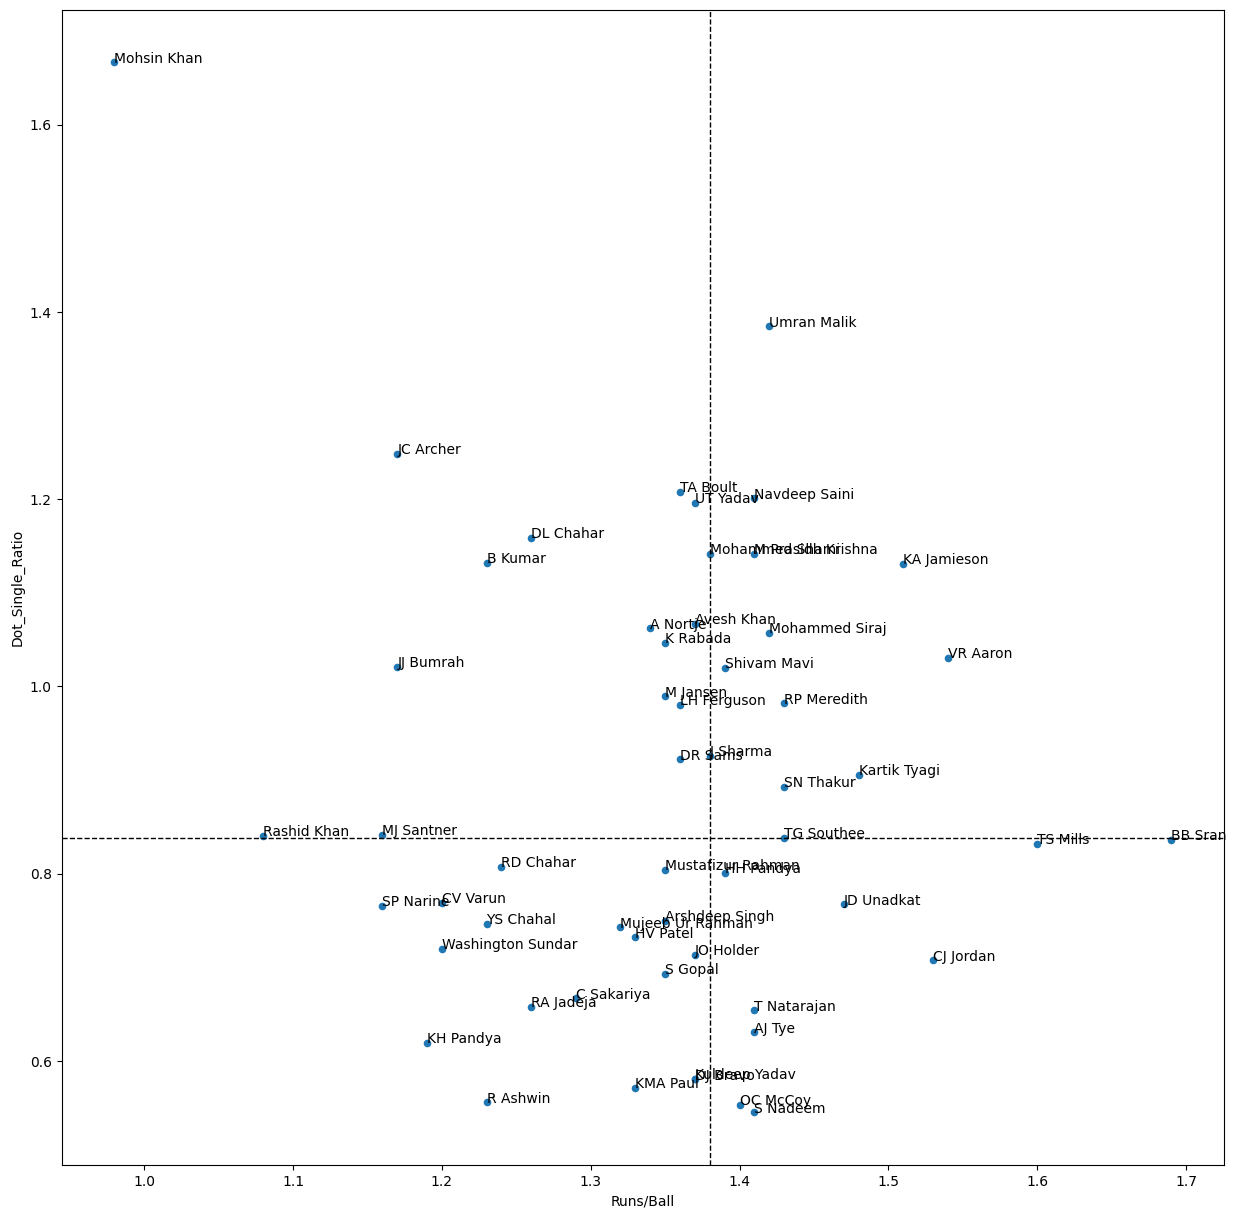

In [63]:
triall1 = []
for name in Bowling_Targets['name']:
  x = df_18[df_18['bowler']==name]
  runs_total = x['total_runs'].sum()
  balls_total = len(x['total_runs'])
  runs_per_ball = round((runs_total/balls_total),2)
  wickets = len(x[x['is_wicket']==1])
  triall1.append([name,runs_per_ball,wickets])
  # get ratio of dot balls to singles
  dot_count = len(x[x['total_runs']==0])
  one_count = len(x[x['total_runs']==1])
  Dot_Single_Ratio = dot_count/one_count

  # get ratio of boundaries to wickets
  four_count = len(x[x['total_runs']==4])
  six_count = len(x[x['total_runs']==6])
  wicket_count = len(x[x['is_wicket']==1])
  Boundaries_Wickets_Ratio = (four_count+six_count)/wicket_count





  if runs_per_ball>=0.5:
    triall1.append([name,runs_per_ball,wickets, Dot_Single_Ratio, Boundaries_Wickets_Ratio])
triall2 = pd.DataFrame(triall1,columns= ['Name','Runs/Ball','Wickets','Dot_Single_Ratio','Boundaries_Wickets_Ratio'])

fig, ax = plt.subplots(figsize = (15,15))
triall2.plot('Runs/Ball', 'Dot_Single_Ratio', kind='scatter', ax=ax)

for i, txt in enumerate(triall2.Name):
    ax.annotate(txt, (triall2['Runs/Ball'].iat[i],triall2['Dot_Single_Ratio'].iat[i]))

ax.axhline(y=triall2['Dot_Single_Ratio'].median(), color='k', linestyle='--', linewidth=1)           
ax.axvline(x=1.38, color='k',linestyle='--', linewidth=1) 
 
plt.show()

# Bowling Analysis
    The opposite becomes true for the bowlers, our x-axis line -- 1.375 runs/ball is the median of the bowling targets. The 80% rule applied would shift the line to 1.25 which is equal to 150 runs.
    
    The bottom left grid is the best grid for the bowlers. The bowlers concede less than 1.375 runs on average and also allows a lot more singles. The top right grid is the worst grid for the bowlers. The bowlers concede more than 1.375 runs on average 

In [64]:


def radar_matchup(df, batsman, bowler):
    # get the counts for the batsman and bowler in different segments
    batsman_counts = striker_segment_count(df)[batsman]
    bowler_counts = bowler_segment_count(df)[bowler]
    
    # create a radar chart
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, polar=True)
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.set_xticks(np.pi/180.0*np.linspace(0, 360, 4, endpoint=False))
    ax.set_xticklabels(['pp', 'mid', 'drink', 'end'])
    ax.plot(np.linspace(0, 2*np.pi, 4, endpoint=False), [batsman_counts[segment] for segment in ['pp', 'mid', 'drink', 'end']], 'o-', label=batsman)
    ax.plot(np.linspace(0, 2*np.pi, 4, endpoint=False), [bowler_counts[segment] for segment in ['pp', 'mid', 'drink', 'end']], 'o-', label=bowler)
    ax.legend()
    plt.show()


In [65]:
def select_players_radar(df):
    batsman_dropdown = widgets.Dropdown(options=list(Batting_Targets['name']), description='Batsman:')
    bowler_dropdown = widgets.Dropdown(options=list(Bowling_Targets['name']), description='Bowler:')
    output = widgets.Output()
    
    def on_batsman_change(change):
        if change['type'] == 'change' and change['name'] == 'value':
            with output:
                clear_output()
                radar_matchup(df, change['new'], bowler_dropdown.value)
                
    def on_bowler_change(change):
        if change['type'] == 'change' and change['name'] == 'value':
            with output:
                clear_output()
                radar_matchup(df, batsman_dropdown.value, change['new'])
                
    batsman_dropdown.observe(on_batsman_change)
    bowler_dropdown.observe(on_bowler_change)
    display(batsman_dropdown)
    display(bowler_dropdown)
    display(output)




In [66]:

# create a copy of Batting_Targets where the numeric columns are to be divided by 30 
# the new column names will be the old column names with '_per_30' appended

Batting_Targets2 = Batting_Targets.copy()
Batting_Targets2['total_balls_per_30'] = Batting_Targets2['total_balls_faced']/30
Batting_Targets2['dot_count_per_30'] = Batting_Targets2['dot_count']/30
Batting_Targets2['1_count_per_30'] = Batting_Targets2['1_count']/30
Batting_Targets2['2_count_per_30'] = Batting_Targets2['2_count']/30
Batting_Targets2['3_count_per_30'] = Batting_Targets2['3_count']/30
Batting_Targets2['4_count_per_30'] = Batting_Targets2['4_count']/30
Batting_Targets2['5_count_per_30'] = Batting_Targets2['5_count']/30
Batting_Targets2['6_count_per_30'] = Batting_Targets2['6_count']/30
Batting_Targets2['wicket_count_per_30'] = Batting_Targets2['wicket_count']/30
Batting_Targets2['boundary_count_per_30'] = Batting_Targets2['boundary_count']/30

#delete the old columns
Batting_Targets2.drop(['total_balls_faced', 'dot_count', '1_count', '2_count', '3_count', '4_count', '5_count', '6_count', 'wicket_count', 'boundary_count'], axis=1, inplace=True)







In [67]:
# create a ranker function that will rank the players based on the selected column and give percentile scores

def ranker(df, column):
    df['rank'+column] = df[column].rank(ascending=False)
    df['percentile'+column] = round(df['rank'+column]/len(df),2)*100
    return df

# run the ranker function on the Batter_Targets2 dataframe for each numeric column
# the new column names will be the old column names with '_rank' appended

Batting_Targets3 = Batting_Targets2.copy()
Batting_Targets3 = ranker(Batting_Targets3, 'total_balls_per_30')
Batting_Targets3 = ranker(Batting_Targets3, 'dot_count_per_30')
Batting_Targets3 = ranker(Batting_Targets3, '1_count_per_30')
Batting_Targets3 = ranker(Batting_Targets3, '2_count_per_30')
Batting_Targets3 = ranker(Batting_Targets3, '3_count_per_30')
Batting_Targets3 = ranker(Batting_Targets3, '4_count_per_30')
Batting_Targets3 = ranker(Batting_Targets3, '5_count_per_30')
Batting_Targets3 = ranker(Batting_Targets3, '6_count_per_30')
Batting_Targets3 = ranker(Batting_Targets3, 'wicket_count_per_30')
Batting_Targets3 = ranker(Batting_Targets3, 'boundary_count_per_30')



In [68]:

data = pd.read_csv('C:/Users/tally/Desktop/Sports Analytics/IPL_Matches_2008_2022.csv')
df = pd.read_csv('C:/Users/tally/Desktop/Sports Analytics/IPL_Matches_2008_2022.csv')


In [70]:
# Get the unique venues
unique_venues = data['City'].unique()

# Create a function to generate the bar chart for each unique venue
def generate_bar_chart(City):
    # Subset the data for the current venue and filter for results of type "runs"
    subset = data[(data['City'] == City) & (data['result'] == 'runs')]
    
    # Get the range of result margins
    result_margins = range(0, int(subset['result_margin'].max()) + 1)
    
    # Create a dictionary to store the count for each result margin
    counts = {result_margin: 0 for result_margin in result_margins}
    
    # Count the number of instances for each result margin
    for index, row in subset.iterrows():
        counts[row['result_margin']] += 1
    
    # Convert the counts dictionary to two separate lists for plotting
    x_values = list(counts.keys())
    y_values = list(counts.values())
    
    # Create the bar chart
    plt.bar(x_values, y_values, width=1.0)
    plt.xlabel('Result Margin')
    plt.ylabel('Count')
    plt.title('Result Margins for ' + City)
    plt.show()

# Create the interactive widget
from ipywidgets import interact, Dropdown

venue_dropdown = Dropdown(options=unique_venues, description='City')

# Define the callback function for the dropdown
def dropdown_callback(change):
    City = change.new
    generate_bar_chart(City)

venue_dropdown.observe(dropdown_callback, names='value')

# Display the widget
display(venue_dropdown)


Dropdown(description='City', options=('Ahmedabad', 'Kolkata', 'Mumbai', 'Navi Mumbai', 'Pune', 'Dubai', 'Sharj…

KeyError: 'result'

In [71]:
# Get the unique venues
venues = df['City'].unique()

@interact(venue=Dropdown(options=venues))
def plot_runs_margin(City):
    # Filter the data for the selected venue and where result is 'runs'
    data = df[(df['City'] == City) & (df['result'] == 'runs')]

    # Compute the histogram of result margins with bins of 5
    margins = data['result_margin']
    bins = np.arange(margins.min(), margins.max() + 6, 5)
    hist, edges = np.histogram(margins, bins=bins)

    # Plot the histogram
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(edges[:-1], hist, width=5)
    ax.set_xticks(edges[:-1] + 2.5)
    ax.set_xticklabels(['{}-{}'.format(i, i+4) for i in edges[:-1]])
    ax.set_xlabel('Runs Margin')
    ax.set_ylabel('Count')
    ax.set_title('Histogram of Runs Margin for {}'.format(City))
    plt.show()


ValueError: cannot find widget or abbreviation for argument: 'City'

In [ ]:
# Define a function to create the bar plot for a given venue
def plot_wickets_result_margin(City):
    # Filter the data for the given venue and result type
    df = data[(data['City'] == City) & (data['result'] == 'wickets')]
    # Get the unique result margins
    margins = sorted(df['result_margin'].unique())
    max_marg = int(max(margins))
    # Count the number of instances for each result margin
    counts = [df[df['result_margin'] == margin]['result_margin'].count() for margin in margins]
    # Plot the bar chart
    fig, ax = plt.subplots(figsize=(10,6))
    ax.bar(margins, counts, width=4, align='center')
    ax.set_xticks(range(0, max_marg+1, 1))
    ax.set_xlabel('Result Margin (wickets)')
    ax.set_ylabel('Count')
    ax.set_title(f'Result Margin Distribution for {City} (wickets)')
    plt.show()

# Get the unique venues
venues = sorted(data['City'].unique())

# Define the interactive widget
@interact(City=Dropdown(options=venues, value=venues[0], description='Venue:'))
def plot_wickets_result_margin_interact(City):
    plot_wickets_result_margin(City)


interactive(children=(Dropdown(description='Venue:', options=('Barabati Stadium', 'Brabourne Stadium', 'Buffal…